In [1]:
"""
This code list implement the Monte Carlo Policy Gradient Alogrithm.
------------------------------------------------------------------
Input:
    differentiable policy function $\pi_{\theta}(a|s)$

Initalize:
    Parameter $\theta$ for policy function

Repeat  experience trajectory:
    Use $\pi_{\theta}(a|s)$ to generate one trajectory $(s_0,a_0,r_1....s_T)$
    Repeat each step in trajectory:
        G <--- cumlated reward at time step t
        Calculate the policy gradient  $\Delta\theta_t = \alpha \Delta_{\theta}log\pi_{\theta}(s_t, a_t)G_t$
------------------------------------------------------------------
"""
import time
import pandas as pd
import gym
import os 
import sys
import numpy as np
from collections import defaultdict, namedtuple

import matplotlib
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable

In [2]:
RENDER_ENV = False
LEARNING_RATE = 0.02
REWARD_DECAY = 0.99
OUTPUT_GRAPH = False
ENVNAME = "CartPole-v0"
HIDDEN_UNITS =[20, 20]
NUM_EPISODES = 200

In [3]:
class Network(nn.Module):
    def __init__(self, n_features, n_action):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(n_features, HIDDEN_UNITS[0])
        self.fc2 = nn.Linear(HIDDEN_UNITS[0], HIDDEN_UNITS[1])
        self.fc3 = nn.Linear(HIDDEN_UNITS[1], n_action)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x                

In [4]:
class MCPG():
    def __init__(self, 
                 n_action, 
                 n_feature, 
                 learning_rate=0.01, 
                 reward_decay=0.95, 
                 ouput_graph=False,
                ):
        self.n_action = n_action
        self.n_features = n_feature
        self.gamma = reward_decay
        self.learning_rate = learning_rate
        self.episode_observation = []
        self.episode_actions = [] 
        self.episode_rewards = []
        self.device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
        self.model = Network(self.n_features, self.n_action)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def choose_action(self, observation):
        state = torch.FloatTensor(observation).to(self.device)
        all_action_value = self.model.forward(state)
        prob_weights = F.softmax(all_action_value,dim=0)
        action_ = torch.distributions.Categorical(prob_weights)
        action = action_.sample().cpu().detach().item()
        return action
    
    def store_transistion(self, s, a, r):
        self.episode_observation.append(s)
        self.episode_actions.append(a)
        self.episode_rewards.append(r)

    def learn(self):
        discounted_episode_reward_normalized = self._discount_and_norm_rewards()
        
        tensor_states = torch.Tensor(np.vstack(self.episode_observation)).to(self.device)
        tensor_rewards = torch.Tensor(discounted_episode_reward_normalized).to(self.device)
        episode_size = len(self.episode_actions)
        tensor_actions=torch.LongTensor(self.episode_actions).reshape(episode_size,1)
        action_onehot = torch.FloatTensor(episode_size, self.n_action)
        action_onehot.zero_()
        action_onehot.scatter_(1, tensor_actions, 1)

        action_prob =  F.softmax(self.model.forward(tensor_states),dim=1)
        action_prob = torch.sum(action_prob * action_onehot, axis=1)
        log_action_prob = torch.log(action_prob)
        loss = -log_action_prob*tensor_rewards
        loss = torch.mean(loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.episode_observation = []
        self.episode_actions = [] 
        self.episode_rewards = []
        return discounted_episode_reward_normalized
    
    def _discount_and_norm_rewards(self):
        discounted_episode_reward = np.zeros_like(self.episode_rewards)
        running_add = 0
        for t in reversed(range(0, len(self.episode_rewards))):
            running_add = running_add * self.gamma + self.episode_rewards[t]
            discounted_episode_reward[t] = running_add
        
        # normalized
        discounted_episode_reward -= np.mean(discounted_episode_reward)
        discounted_episode_reward /= np.std(discounted_episode_reward)
        return discounted_episode_reward        

In [5]:
def plot_episode_stats1(rec, xlabel, ylabel,title):
    fig = plt.figure(figsize=(20, 10), facecolor = "white")
    ax = fig.add_subplot(111)
    ax.plot(rec) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return fig

def plot_episode_stats2(stats):
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(20, 10))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    return fig3

def Plot_the_result(rec):
    # Plot episode length over time
    episode_lengths = rec.episode_lengths
    fig = plot_episode_stats1(episode_lengths, 
                       xlabel = "Episode",
                       ylabel = "Episode Length",
                       title = "Episode length over Time"
            )
    fig.show()
    fig.savefig("./log/MCPG_pytorch_cpu_CartPole_EpisodeLength.jpg")

    # Plot Episode reward over time
    smoohing_window = 10
    reward_smooths = pd.Series(rec.episode_rewards).rolling(smoohing_window,\
                    min_periods = smoohing_window).mean()
    fig = plot_episode_stats1(reward_smooths, 
                       xlabel = "Episode",
                       ylabel = "Episode Reward",
                       title = "Episode reward over time"
            )
    fig.show()
    fig.savefig("./log/MCPG_pytorch_cpu_CartPole_EpisodeReward.jpg")
    
    # Plot Episode per time step
    fig = plot_episode_stats2(rec)
    fig.show()
    fig.savefig("./log/MCPG_pytorch_cpu_CartPole_EpisodePerTimeStep.jpg")

In [6]:
def update(RL, env, num_episodes):
    # Track the statistics of the result
    record = namedtuple("Record", ["episode_lengths","episode_rewards"])
    
    rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        if 0 == (i_episode +1) % 1:
            print("This the episode {}/{}".format(i_episode, num_episodes), end = "\r")
        observation = env.reset()
        step =0
        reward_cum = 0
        done = False
        while True:
            #env.render()
            if RENDER_ENV:
                env.render()
            # step1: choose action based on the state
            action = RL.choose_action(observation)
            # step2: take the action in the enviroment
            observation_next, reward, done, info = env.step(action)
            # step3: store the transistion for training
            RL.store_transistion(observation, action, reward)
            # update the record
            step += 1
            rec.episode_lengths[i_episode] = step 
            rec.episode_rewards[i_episode] += reward
            if done or rec.episode_rewards[i_episode] > 2000:
                # step4: train the network
                RL.learn()
                print("The reward at episode {} is {}.".format(i_episode, 
                                                              rec.episode_rewards[i_episode]))
                break
            # step5: save the new state
            observation = observation_next
    print("Finished")
    env.close()
    return rec

The reward at episode 0 is 19.0.
The reward at episode 1 is 16.0.
The reward at episode 2 is 14.0.
The reward at episode 3 is 24.0.
The reward at episode 4 is 17.0.
The reward at episode 5 is 16.0.
The reward at episode 6 is 16.0.
The reward at episode 7 is 40.0.
The reward at episode 8 is 21.0.
The reward at episode 9 is 64.0.
The reward at episode 10 is 49.0.
The reward at episode 11 is 45.0.
The reward at episode 12 is 38.0.
The reward at episode 13 is 21.0.
The reward at episode 14 is 47.0.
The reward at episode 15 is 54.0.
The reward at episode 16 is 51.0.
The reward at episode 17 is 40.0.
The reward at episode 18 is 104.0.
The reward at episode 19 is 55.0.
The reward at episode 20 is 34.0.
The reward at episode 21 is 30.0.
The reward at episode 22 is 40.0.
The reward at episode 23 is 32.0.
The reward at episode 24 is 36.0.
The reward at episode 25 is 116.0.
The reward at episode 26 is 105.0.
The reward at episode 27 is 69.0.
The reward at episode 28 is 98.0.
The reward at episode

/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


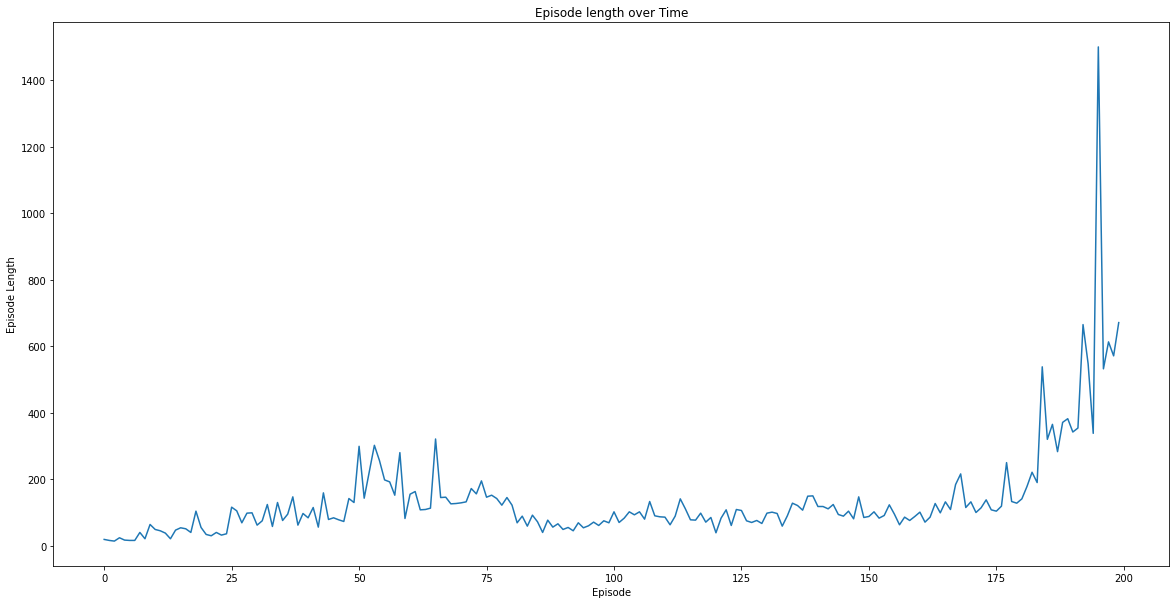

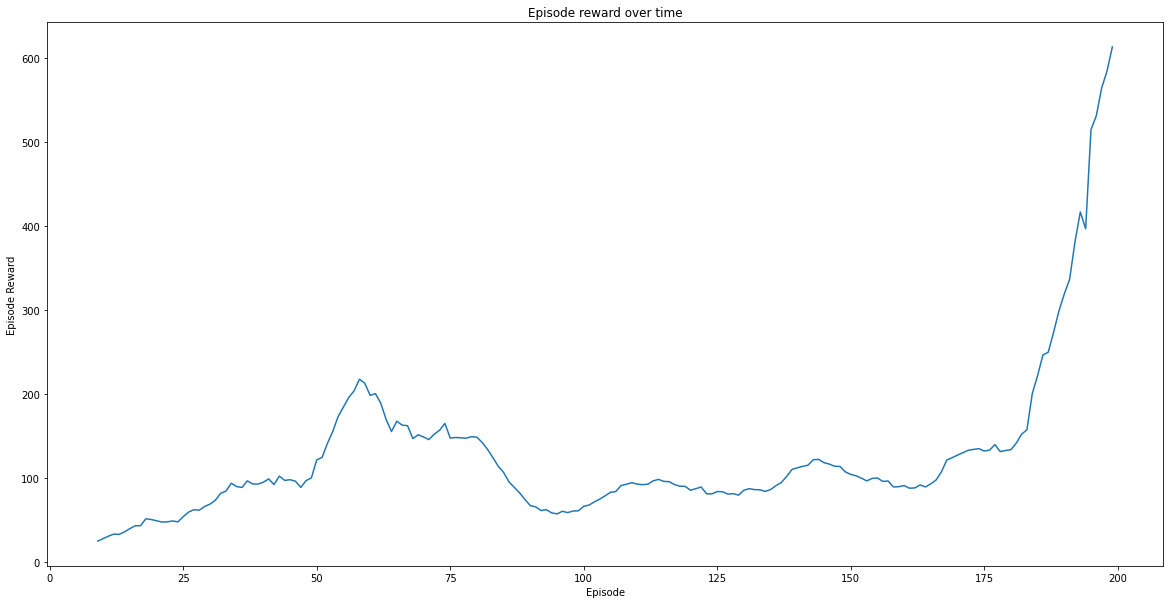

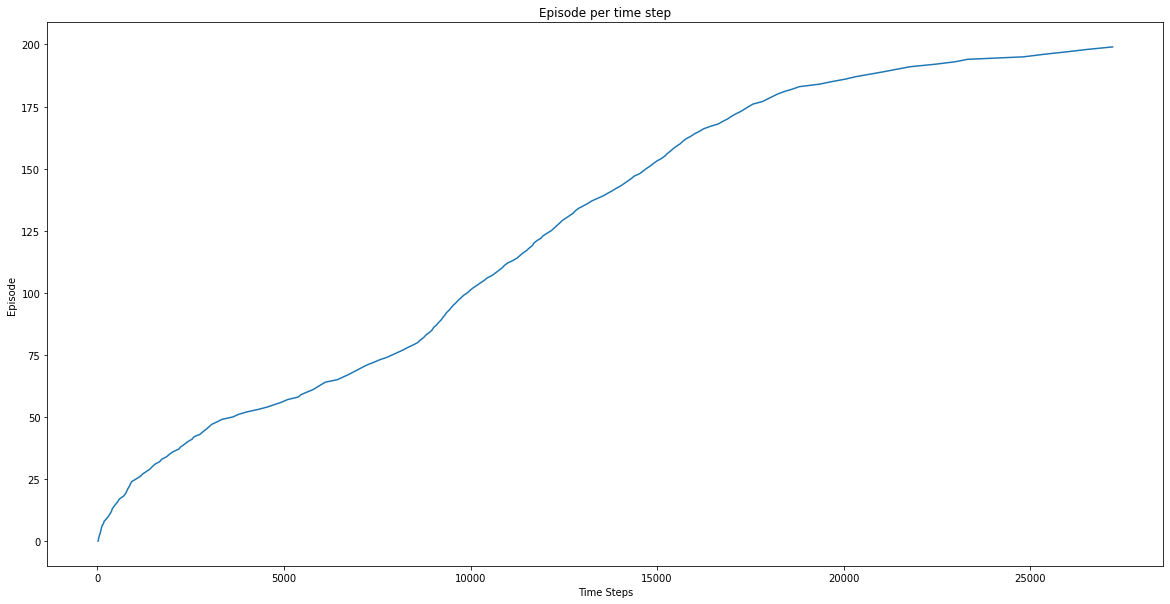

In [10]:
if __name__ == "__main__":
    env = gym.make(ENVNAME)
    env = env.unwrapped
    RL = MCPG(n_action=env.action_space.n,
             n_feature=env.observation_space.shape[0],
             learning_rate=LEARNING_RATE,
             reward_decay=REWARD_DECAY,
             ouput_graph=OUTPUT_GRAPH)
    rec = update(RL, env, num_episodes=NUM_EPISODES)
    #Plot the result
    Plot_the_result(rec)